In [1]:
import stanza
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict, Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords

In [2]:

# 🔹 Download & Load Stanza Greek Model
stanza.download('el')
nlp_stanza = stanza.Pipeline(lang='el', processors='tokenize,pos,lemma')

2025-04-05 19:05:28 INFO: Downloaded file to C:\Users\Katerina\stanza_resources\resources.json
2025-04-05 19:05:28 INFO: Downloading default packages for language: el (Greek) ...
2025-04-05 19:05:29 INFO: File exists: C:\Users\Katerina\stanza_resources\el\default.zip
2025-04-05 19:05:31 INFO: Finished downloading models and saved to C:\Users\Katerina\stanza_resources
2025-04-05 19:05:31 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-04-05 19:05:31 INFO: Downloaded file to C:\Users\Katerina\stanza_resources\resources.json
2025-04-05 19:05:31 WARNING: Language el package default expects mwt, which has been added
2025-04-05 19:05:32 INFO: Loading these models for language: el (Greek):
| Processor | Package      |
----------------------------
| tokenize  | gdt          |
| mwt       | gdt          |
| pos       | gdt_nocharlm |
| lemma     | gdt_nocharlm |

2025-04-05 19:05:32 INFO: Using device: cpu
2025-04-05 19:05:32 INFO: Loading: tokenize
2025-04-05 19:05:32 INFO: Loading: mwt
2025-04-05 19:05:32 INFO: Loading: pos
2025-04-05 19:05:36 INFO: Loading: lemma
2025-04-05 19:05:36 INFO: Done loading processors!


In [3]:

# 🔹 Define Custom Stopwords BEFORE Stanza Processing
custom_stopwords = set([
    "και", "να", "το", "μου", "του", "της", "εγω", "ένα", "σε", "με", "για",
    "θα", "απο", "αυτό", "αυτή", "αυτο", "ότι", "πως", "πολύ", "εδώ", "εκεί", "είμαι","ακόμη", "αυτές", "στο","στις", "στους","στα","στο","στη","δικό", "δικού"
"δικός",'εσάς', 'την', 'τα', "είναι",'μια', 'μία','έχει', 'είχαμε', 'είχα', 'έχουμε', 'έχετε','ήθελα','κάνετε', 'κάνει', 'έκανα','κάποιον', 'κάποιο', 'κάποιες','λέω', 'δω', 'μπω', 'πω', 'πείτε','τους', 'σας', 'μας','μπορείτε', 'μπορούσατε', 'μπορούσα', 'μπορεί',
'τη', 'τους', 'τo', 'η', 'οι', 'τα', 'το', 'την', 'των', 'τις', 'τον','όλων', 'όλης', 'όλο', 'όλοι', 'όλους','οποίο','ποιους', 'ποια', 'ποιο', 'ποιες','ποιον','πόση','πόσες','πόση', 'πόσα','πόσα','σ',"σε"]) 


custom_word_mapping = {
    "'τηλέφωνό": "τηλέφωνο",
    "τηλέφων": "τηλέφωνο",
    "τηλέφωνό": "τηλέφωνο",
    "τηλεφώνου": "τηλέφωνο",
    "υπολοίπου": "υπόλοιπος",
    "υποβάλω": "υπόβάλλω",
    "υποβολής" : "υποβάλλω",
    "χρωστάω" : "χρέος"
}


In [4]:

# 🔹 Dictionary to store word mappings (before → after lemmatization)
word_mapping = defaultdict(set)

In [9]:
# ✅ **Preprocessing Function (Removes Stopwords + Applies Manual Remapping)**
def preprocess_text(text):
    if pd.isnull(text):  # Handle missing values
        return ""
    
    # Convert text to lowercase & Remove punctuation
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  
    
    # Remove Stopwords before Stanza Processing
    words = text.split()  
    words = [word for word in words if word not in custom_stopwords]  # Remove stopwords
    cleaned_text = " ".join(words)  # Reconstruct sentence
    
    #  Pass Cleaned Text to Stanza for Lemmatization
    doc = nlp_stanza(cleaned_text)
    lemmatized_text = []
    
    for sentence in doc.sentences:
        for word in sentence.words:
            original_word = word.text.lower()
            lemmatized_word = word.lemma
            
            # 🔹 **Apply Custom Mapping (if exists)**
            if lemmatized_word in custom_word_mapping:
                corrected_lemma = custom_word_mapping[lemmatized_word]
            else:
                corrected_lemma = lemmatized_word  # Keep original lemma

            # Store mapping only if the lemma differs from the original word
            if original_word != corrected_lemma:
                word_mapping[corrected_lemma].add(original_word)

            lemmatized_text.append(corrected_lemma)

    return " ".join(lemmatized_text)

In [11]:
# 🔹 Load the dataset
df = pd.read_csv("C:/Users/Katerina/Documents/Chatbot/Customer Utterances.csv")  
df["lemmatized_queries"] = df["Utterance"].apply(preprocess_text)  

In [12]:


# 🔹 Convert word mappings dictionary to a DataFrame
word_mapping_df = pd.DataFrame([(lemma, list(words)) for lemma, words in word_mapping.items()], 
                               columns=["Lemmatized_Word", "Original_Words"])

In [13]:

#  Sentence Embeddings with Sentence-BERT
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
embeddings = model.encode(df["lemmatized_queries"].tolist())

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\Katerina\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Katerina\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

C:\Users\Katerina\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Katerina\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Katerina\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Katerina\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory le

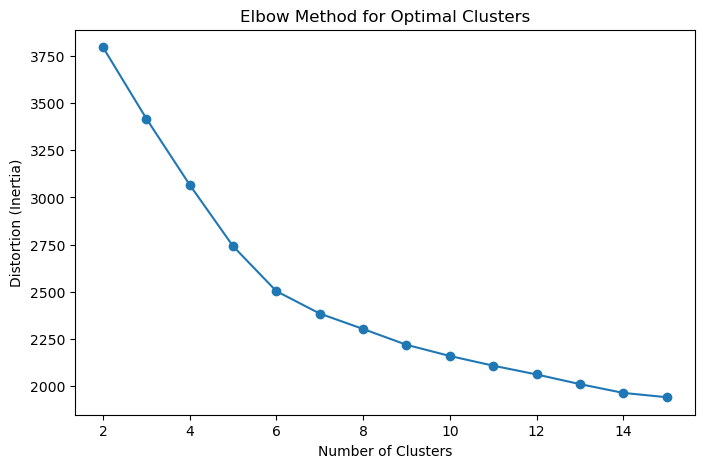

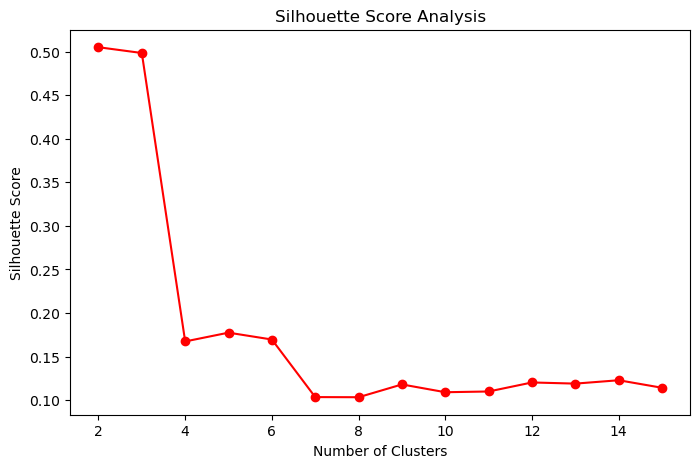

In [17]:

#  K-Means Clustering
def optimal_clusters(embeddings, max_clusters=15):
    distortions = []
    silhouette_scores = []
    cluster_range = range(2, max_clusters+1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(embeddings)
        
        # Calculate Elbow Method distortion score
        distortions.append(kmeans.inertia_)

        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(embeddings, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

    return cluster_range, distortions, silhouette_scores

# Find the optimal number of clusters using Elbow & Silhouette methods
cluster_range, distortions, silhouette_scores = optimal_clusters(embeddings)

#  Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, distortions, marker="o", linestyle="-")
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion (Inertia)")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

#  Plot Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker="o", linestyle="-", color="red")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Analysis")
plt.show()

In [19]:

#  Perform final K-Means clustering using the best number of clusters
optimal_k = 7 #cluster_range[silhouette_scores.index(max(silhouette_scores))]  # Best cluster count
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = final_kmeans.fit_predict(embeddings)

#  Function to Predict Cluster for New Input
def predict_cluster(user_input):
    processed_input = preprocess_text(user_input)
    input_embedding = model.encode([processed_input])
    cluster = final_kmeans.predict(input_embedding)[0]
    print(f"🔹 The input belongs to Cluster {cluster}")
    return cluster

C:\Users\Katerina\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [21]:

# Function to Find Top 5 Most Frequent Words in Each Cluster
def get_top_words_per_cluster():
    cluster_word_counts = defaultdict(Counter)

    for _, row in df.iterrows():
        words = row["lemmatized_queries"].split()
        cluster_word_counts[row["Cluster"]].update(words)

    top_words = {cluster: word_counts.most_common(5) for cluster, word_counts in cluster_word_counts.items()}
    
    # Convert to DataFrame for better visualization
    top_words_df = pd.DataFrame([
        {"Cluster": cluster, "Top_Words": [word for word, _ in words]} for cluster, words in top_words.items()
    ])
    
    return top_words_df

In [23]:

# 🔹 Save processed data and mappings
df.to_csv("lemmatized_queries_with_clusters.csv", index=False)
word_mapping_df.to_csv("lemmatization_mapping_stanza.csv", index=False)
top_words_df = get_top_words_per_cluster()
top_words_df.to_csv("top_words_per_cluster.csv", index=False)

In [25]:

# 🔹 Display the mapping DataFrame
display(word_mapping_df)


,Lemmatized_Word,Original_Words
0,πάσος,[πάσο]
1,βάγω,[βάλω]
2,φοιτητικός,"[φοιτητικά, φοιτητικό]"
3,διακανονισμός,"[διακανονισμό, διακανονισμού, διακανονισμούς]"
4,ληξιπρόθεσμος,[ληξιπρόθεσμο]
...,...,...
163,εισερχομένος,[εισερχομένων]
164,βγίσκω,[βγήκε]
165,άμεσος,[άμεση]
166,συνάδελφος,[συνάδελφό]


In [27]:
display(top_words_df)

,Cluster,Top_Words
0,6,"[μπορώ, πώς, πού, που, κάνω]"
1,4,"[θέλω, λογαριασμός, κάνω, επιθυμώ, ομιλία]"
2,1,"[λογαριασμός, έχω, ραντέβος, βοήθεια, υπηρεσία]"
3,3,"[tablet, νέος, αγοράζω, τιμή, αγορά]"
4,2,"[θέλω, λογαριασμός, κάνω, γίνομαι, διακανονισμός]"
5,5,"[tethering, πώς, κάνω, δε, δουλεύω]"
6,0,"[hotspot, πώς, κάνω, δε, κινητό]"


In [29]:

# 🔹 Show processed DataFrame
df.head()



,Utterance,Cluster,lemmatized_queries
0,πρέπει να έχω πάσο για να βάλω φοιτητικό,6,πρέπει έχω πάσος βάγω φοιτητικός
1,θα ήθελα να κάνω διακανονισμό σε όλο το ληξιπρ...,4,κάνω διακανονισμός ληξιπρόθεσμος
2,θέλω χρόνο για να μιλάω,4,θέλω χρόνος μιλάω
3,χρειάζομαι ανανέωση,1,χρειάζομαι ανανέωση
4,τo παραστατικό του σταθερού μου,6,παράστατικός σταθερός


In [31]:
# **Simple CLI for Testing**
if __name__ == "__main__":
    while True:
        query = input("\n💬 Enter your query (or type 'exit' to quit): ")
        if query.lower() == 'exit':
            print("👋 Exiting... Have a great day!")
            break
        intent = predict_intent(query)
        print(f"🔹 Predicted Intent: {intent}")


💬 Enter your query (or type 'exit' to quit):  exit


👋 Exiting... Have a great day!
